In [3]:
%pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score


# config pod wizualizacje
sns.set_theme(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Note: you may need to restart the kernel to use updated packages.


### Zadanie 1

In [4]:
data1 = pd.read_csv("data1.csv")

data1.describe()

,x1,x2,y
count,100.000,100.000,100.000
mean,-16.516,194.787,-187.673
std,251.829,114.164,299.079
min,-589.776,6.635,-916.995
25%,-90.397,90.160,-325.495
50%,-0.976,199.571,-158.722
75%,89.149,294.257,-41.646
max,558.750,394.755,805.000


Wizualizacje

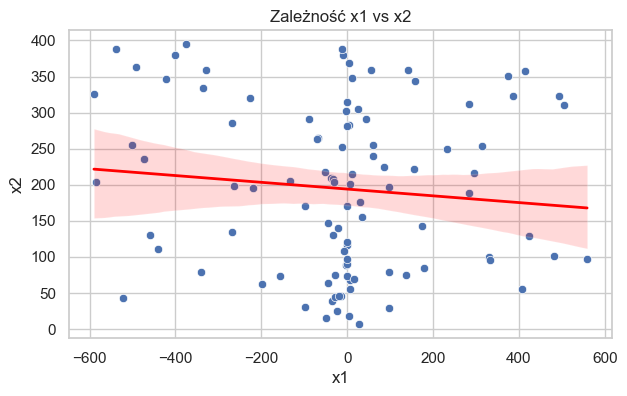

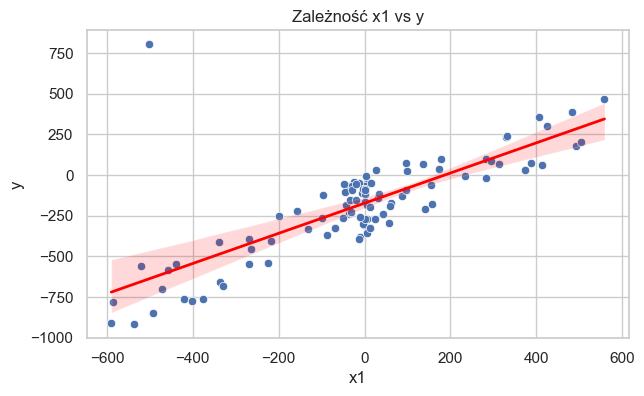

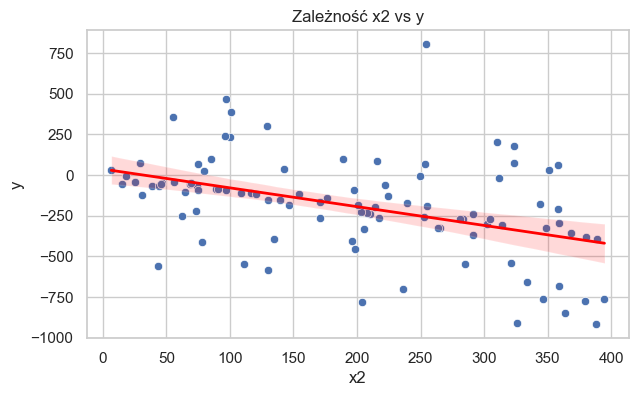

,x1,x2,y
x1,1.000,-0.103,0.781
x2,-0.103,1.000,-0.441
y,0.781,-0.441,1.000


In [5]:


# 1. Wykres x1 vs x2
plt.figure(figsize=(7, 4))
sns.scatterplot(data=data1, x='x1', y='x2')

sns.regplot(data=data1, x='x1', y='x2', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Zależność x1 vs x2')
plt.show()

# 2. Wykres x1 vs y
plt.figure(figsize=(7, 4))
sns.scatterplot(data=data1, x='x1', y='y')
sns.regplot(data=data1, x='x1', y='y', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Zależność x1 vs y')
plt.show()

# 3. Wykres x2 vs y
plt.figure(figsize=(7, 4))
sns.scatterplot(data=data1, x='x2', y='y')
sns.regplot(data=data1, x='x2', y='y', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Zależność x2 vs y')
plt.show()



correlation_matrix = data1.corr()
display(correlation_matrix)





Silna korelacja miedzy x1 ~ y. Umiarkowana miedzy x2 ~ y. Zadna, miedzy x1 ~ x2

#### Zadanie 1.1: Obserwacje i Wnioski

##### Obserwacja: zmienne x1, x2 mają różne skale. x1 ma znacznie wieksze std i szerszy zakres wartosci niz x2. 
##### Regresja liniowa jest "wrazliwa na skale zmiennych", co jest nasza pierwsze wskazowka do preprocessingu.

##### Obserwacja (x1 vs y): silna korelacja, potwierdzona przez macierz korelacji. x1 moze byc dobrym predyktorem.
##### Obserwacja (x2 vs y): umiarkowana korelacja
##### Obserwacja (x1 vs x2): słaba korelacja

#### Wnioski:
##### Regresja liniowa jest odpowiednim modelem.
##### Kluczowym problem, który móglby wystapić to współliniowość. Ale nie wystepuje, bo x1 !~ x2.
##### Można wiec je łatwo od siebie rozróznić.

#### Jak przygotować dane?
##### Musimy uwazac na dwie rzeczy.
##### 1. Rózne skale zmiennych. Regresja jest wrazliwa na skale. Wypada przeprowadzic normalizacje.
##### 2. x2 jest slabym, zaszumionym predyktorem. Moze warto zbudowac prostszy model y ~ x1?


---

Zróbmy preprocessing.
Przede wszystkim przeprowadźmy standardyzacje i normalizacje.
Kolejnosc:
1. Podzielmy dane na treningowe i testowe
2. Naucz (StandardScaler) TYLKO na X_train
3. Uczymy tez, aby znormalizował X_train
4. Uzyjmy tego samego, by przekształcic X_test 

In [6]:
X = data1[['x1', 'x2']]
y = data1['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rozmiary
print(f'Rozmiar X_train : {X_train.shape}')
print(f'Rozmiar X_test  : {X_test.shape}')

Rozmiar X_train : (80, 2)
Rozmiar X_test  : (20, 2)


In [7]:
def preprocess_data(X_train, y_train):
    """
    Zwraca:
        X_train_scaled: przeszkalowane dane X_train
        y_train: oryginalne dane y_train
        scaler: nauczony (dopasowany) obiekt StandardScaler
        nie modyfikujmy y_train. afaik: to sie zostawia
    """
    scaler = StandardScaler()
    # obliczamy srednia i odchylenie. i przeskalowanie X_train
    X_train_scaled = scaler.fit_transform(X_train)
    return X_train_scaled, y_train, scaler

X_train_scaled, y_train_scaled, scaler = preprocess_data(X_train, y_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
print("Dane po standardyzacji (fragment):")
display(X_train_scaled_df.head())

print("\nStatystyki danych po standardyzacji (X_train_scaled_df)")
display(X_train_scaled_df.describe())


Dane po standardyzacji (fragment):


,x1,x2
0,-0.066,-1.154
1,0.239,-0.370
2,1.701,1.397
3,-0.018,-0.584
4,0.061,1.665



Statystyki danych po standardyzacji (X_train_scaled_df)


,x1,x2
count,80.000,80.000
mean,-0.000,0.000
std,1.006,1.006
min,-2.160,-1.657
25%,-0.302,-0.931
50%,0.109,0.058
75%,0.482,0.946
max,2.051,1.717


### Zadanie 2

2.1 80% treningowy, 20% testowy
Czy bedzie on taki sam przy budowaniu pojedynczego modelu, jak rowniez sytuacji, kiedy chcemy wybrac jeden sposrod kilku modeli?
NIE:
1. Sytuacja 1: budowa pojedynczego modelu. okej, wtedy trenuemy na 80% danych, oceniamy na 20% i koniec.
2. Sytuacja 2: wybor sposrod kilku modeli. wtedy najlepiej miec trzy dane: 60% trenignowe, 20% walidacyjny, by wybrac ten lepszy, 20% - testowy do ostatecznej oceny tylko tego jednego wybranego modelu.

In [8]:
# model 1 : dane surowe

model_raw = LinearRegression()

model_raw.fit(X_train, y_train)
print(f'W danych surowych wyraz wolny wynosi: {model_raw.intercept_}\n')
coef_df_raw = pd.DataFrame(model_raw.coef_, index=X_train.columns, columns=['Wspolczynnik (waga)'])
print("Wspolczynniki (a1, a2):")
display(coef_df_raw)


# model 2 : dane scaled

model_scaled = LinearRegression()

model_scaled.fit(X_train_scaled, y_train_scaled)
print(f'W danych scaled wyraz wolny wynosi: {model_scaled.intercept_}\n')
coef_df_scaled = pd.DataFrame(model_scaled.coef_, index=X_train.columns, columns=['Współczynnik (Waga)'])
print("Wspolczynniki (a1, a2):")
display(coef_df_scaled)


W danych surowych wyraz wolny wynosi: 10.154157940063072

Wspolczynniki (a1, a2):


,Wspolczynnik (waga)
x1,0.866
x2,-0.931


W danych scaled wyraz wolny wynosi: -197.97250712049996

Wspolczynniki (a1, a2):


,Współczynnik (Waga)
x1,225.171
x2,-107.123


W przeskalowanych danych widać o wiele wiekszy wplyw x1 na y niz x2 niz jest to w Raw danych

In [9]:
# przygotowanie danych X_test
# UZYWAYM TYLKO .transform() zamiast .fit_transform()

from numpy import mean


X_test_scaled = scaler.transform(X_test)

# predykcja oboma modelami
y_pred_raw = model_raw.predict(X_test)
y_pred_scaled = model_scaled.predict(X_test_scaled)

# surowe
mse_raw = mean_squared_error(y_test, y_pred_raw) # blad sredniokwadratowy
r2_raw = r2_score(y_test, y_pred_raw)            # im blizej 1.0 tym lepiej

# przeskalowane
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)      # wspolczynik determinacji

r2_raw_score = model_raw.score(X_test, y_test)   # just in case
r2_scaled_score = model_scaled.score(X_test_scaled, y_test)

print(f'R2 raw score : {r2_raw_score:.3f}')
print(f'R2 scaled score : {r2_scaled_score:.3f}')


evaluation_results = {
    'Model' : ['Raw', 'Scaled'],
    'MSE' : [mse_raw, mse_scaled],
    'R2'  : [r2_raw, r2_scaled]
}

evaluation_df = pd.DataFrame(evaluation_results)
print('Wyniki ewaluacji modeli')
display(evaluation_df)




R2 raw score : 0.985
R2 scaled score : 0.985
Wyniki ewaluacji modeli


,Model,MSE,R2
0,Raw,1043.044,0.985
1,Scaled,1043.044,0.985


Nasz baseline model bedzie ignorowal calkowicie x2 i wykorzystamy jedynie x1
y = a1x2 + b

In [10]:
# 2.2, 2.3

X_train_baseline = X_train[['x1']]
X_test_baseline = X_test[['x1']]

print(f'Ksztalt danych treningowych: {X_train_baseline.shape}')

model_baseline = LinearRegression()
model_baseline.fit(X_train_baseline, y_train)

print(f'W baseline modelu wyraz wolny wynosi: {model_baseline.intercept_}\n')
print(f'Wspolczynik (a1) dla x1 wynosi: {model_baseline.coef_[0]:.3f}')

y_pred_baseline = model_baseline.predict(X_test_baseline)

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f'MSE dla baseline : {mse_baseline:.3f}')
print(f'R2 dla baseline wynosi: {r2_baseline:.3f}')

Ksztalt danych treningowych: (80, 1)
W baseline modelu wyraz wolny wynosi: -172.90358608904506

Wspolczynik (a1) dla x1 wynosi: 0.889
MSE dla baseline : 13685.974
R2 dla baseline wynosi: 0.797


In [11]:
final_evaluation_results = {
    'Model': [
        'Bazowy (Baseline, y ~ x1)',
        'Liniowy (Surowe dane, y ~ x1 + x2)',
        'Liniowy (Przeskalowane dane, y ~ x1 + x2)'
    ],
    'MSE': [mse_baseline, mse_raw, mse_scaled],
    'R2': [r2_baseline, r2_raw, r2_scaled]
}

final_evaluation_df = pd.DataFrame(final_evaluation_results)
display(final_evaluation_df)

,Model,MSE,R2
0,"Bazowy (Baseline, y ~ x1)",13685.974,0.797
1,"Liniowy (Surowe dane, y ~ x1 + x2)",1043.044,0.985
2,"Liniowy (Przeskalowane dane, y ~ x1 + x2)",1043.044,0.985


In [12]:
# placeholder na ewluacje modelu na danych udstoepninych w trakcie pracowni

### Zadanie 3

In [13]:
data_adv = pd.read_csv('advertising.csv')
data_adv.describe()

,TV,Radio,Newspaper,Sales
count,200.000,200.000,200.000,200.000
mean,147.042,23.264,30.554,15.131
std,85.854,14.847,21.779,5.284
min,0.700,0.000,0.300,1.600
25%,74.375,9.975,12.750,11.000
50%,149.750,22.900,25.750,16.000
75%,218.825,36.525,45.100,19.050
max,296.400,49.600,114.000,27.000


y -> sales
###
Mamy różną skalę średnią, więc sobie ja wyskalujemy, by poprawnie interpretować wagi modelu.

In [14]:
X_adv = data_adv[['TV', 'Radio', 'Newspaper']]
y_adv = data_adv['Sales']

correlation_matrix_adv = data_adv.corr()
display(correlation_matrix_adv)

,TV,Radio,Newspaper,Sales
TV,1.000,0.055,0.057,0.901
Radio,0.055,1.000,0.354,0.350
Newspaper,0.057,0.354,1.000,0.158
Sales,0.901,0.350,0.158,1.000


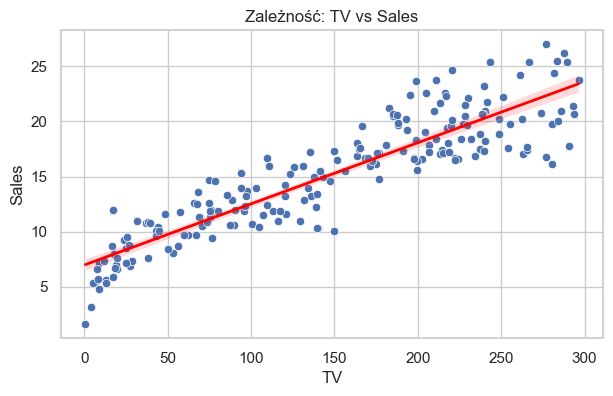

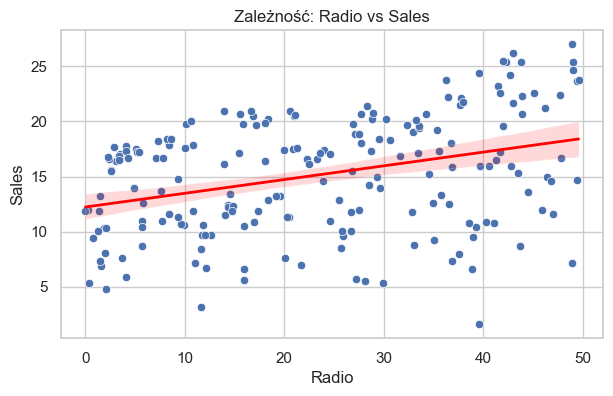

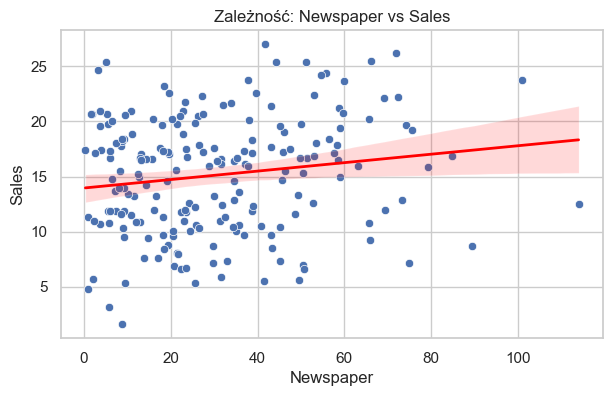

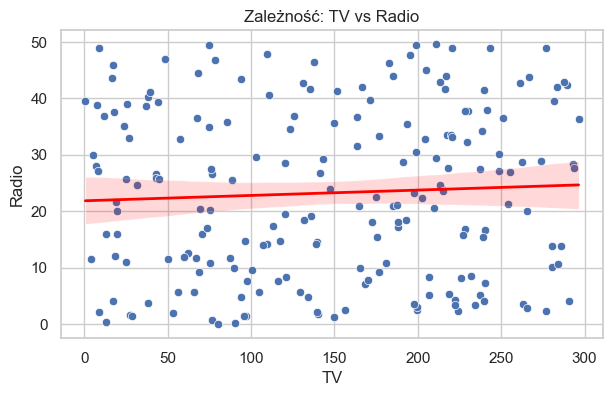

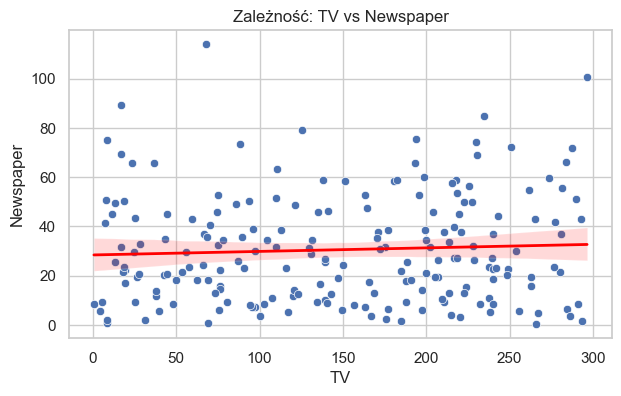

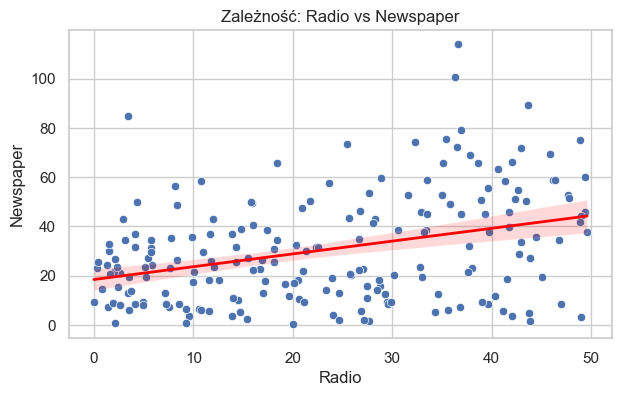

In [15]:

# 1. TV vs Sales
plt.figure(figsize=(7, 4))
sns.scatterplot(data=data_adv, x='TV', y='Sales')
sns.regplot(data=data_adv, x='TV', y='Sales', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Zależność: TV vs Sales')
plt.show()

# 2. Radio vs Sales
plt.figure(figsize=(7, 4))
sns.scatterplot(data=data_adv, x='Radio', y='Sales')
sns.regplot(data=data_adv, x='Radio', y='Sales', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Zależność: Radio vs Sales')
plt.show()

# 3. Newspaper vs Sales
plt.figure(figsize=(7, 4))
sns.scatterplot(data=data_adv, x='Newspaper', y='Sales')
sns.regplot(data=data_adv, x='Newspaper', y='Sales', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Zależność: Newspaper vs Sales')
plt.show()


# --- Wykresy: Predyktor vs Predyktor (Współliniowość) ---

# 4. TV vs Radio
plt.figure(figsize=(7, 4))
sns.scatterplot(data=data_adv, x='TV', y='Radio')
sns.regplot(data=data_adv, x='TV', y='Radio', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Zależność: TV vs Radio')
plt.show()

# 5. TV vs Newspaper
plt.figure(figsize=(7, 4))
sns.scatterplot(data=data_adv, x='TV', y='Newspaper')
sns.regplot(data=data_adv, x='TV', y='Newspaper', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Zależność: TV vs Newspaper')
plt.show()

# 6. Radio vs Newspaper
plt.figure(figsize=(7, 4))
sns.scatterplot(data=data_adv, x='Radio', y='Newspaper')
sns.regplot(data=data_adv, x='Radio', y='Newspaper', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Zależność: Radio vs Newspaper')
plt.show()



przygotowanie danych

In [16]:
X_adv = data_adv.drop('Sales', axis = 1)
y_adv = data_adv['Sales']

X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_adv, y_adv, test_size=0.2, random_state=42
)

def preprocess_data(X_train, y_train):
    """
    Zwraca:
    - X_train_scaled : przeskalowane dane X_train
    - y_train: oryginalne dane y_train
    - scaler: nauczony, dopasowany obiekt
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    return X_train_scaled, y_train, scaler

In [17]:
# 3.2


# model 1 : surowe dane

model_adv_raw = LinearRegression()
model_adv_raw.fit(X_train_adv, y_train_adv) # trenowanie modelu
print(f'Wyraz wolny (b) : {model_adv_raw.intercept_:.3f}')
coef_df_adv_raw = pd.DataFrame(model_adv_raw.coef_, index=X_train_adv.columns, columns=['Wsołczynnik (Waga)'])
display(coef_df_adv_raw)




Wyraz wolny (b) : 4.714


,Wsołczynnik (Waga)
TV,0.055
Radio,0.101
Newspaper,0.004


In [18]:
X_train_adv_scaled, y_train_adv_scaled, scaler_adv = preprocess_data(X_train_adv, y_train_adv)
model_adv_scaled = LinearRegression()

model_adv_scaled.fit(X_train_adv_scaled, y_train_adv_scaled)
print(f"Wyraz wolny (b): {model_adv_scaled.intercept_:.3f}")
coef_df_adv_scaled = pd.DataFrame(model_adv_scaled.coef_, index=X_train_adv.columns, columns=['Wspolczynnik (Waga)'])

print(coef_df_adv_scaled)

Wyraz wolny (b): 15.331
           Wspolczynnik (Waga)
TV                       4.587
Radio                    1.490
Newspaper                0.088


In [19]:
# 3.3
from sklearn.metrics import mean_squared_error, r2_score


X_test_adv_scaled = scaler_adv.transform(X_test_adv)

y_pred_adv_raw = model_adv_raw.predict(X_test_adv)
y_pred_adv_scaled = model_adv_scaled.predict(X_test_adv_scaled)


# raw
mse_adv_raw = mean_squared_error(y_test_adv, y_pred_adv_raw)
r2_adv_raw = r2_score(y_test_adv, y_pred_adv_raw)

# scaled
mse_adv_scaled = mean_squared_error(y_test_adv, y_pred_adv_scaled)
r2_adv_scaled = r2_score(y_test_adv, y_pred_adv_scaled)

evaluation_results_adv = {
    'Model': ['Raw', 'Scaled'],
    'MSE': [mse_adv_raw, mse_adv_scaled],
    'R2': [r2_adv_raw, r2_adv_scaled]
}


evaluation_df_adv = pd.DataFrame(evaluation_results_adv)
display(evaluation_df_adv)

,Model,MSE,R2
0,Raw,2.908,0.906
1,Scaled,2.908,0.906


In [20]:
# placeholder 3.4

### Zadanie 4

In [21]:
# 4.1
data4 = pd.read_csv('data4.csv')
#data4.head()
#data4.info()
data4.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,y
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,...,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
mean,0.066,-0.091,0.149,-0.009,0.067,0.139,-0.020,0.136,0.048,0.022,...,0.116,0.182,-0.021,0.141,0.165,-0.084,0.011,-0.014,-0.033,10.845
std,1.030,0.978,0.934,0.896,0.928,0.924,0.979,0.946,0.904,1.079,...,1.025,1.045,1.053,0.922,1.089,1.063,1.186,1.007,0.885,93.584
min,-2.896,-1.975,-2.499,-2.173,-2.424,-1.703,-1.749,-1.761,-2.472,-3.241,...,-2.199,-2.620,-2.591,-2.872,-2.153,-2.697,-2.940,-2.152,-2.651,-189.274
25%,-0.535,-0.857,-0.356,-0.640,-0.496,-0.553,-0.767,-0.656,-0.586,-0.650,...,-0.660,-0.532,-0.677,-0.436,-0.609,-0.946,-0.684,-0.775,-0.555,-59.519
50%,-0.028,-0.076,0.179,-0.016,0.131,0.146,-0.021,0.147,-0.012,0.044,...,0.214,0.046,-0.095,0.175,0.024,-0.004,0.092,-0.023,0.040,1.554
75%,0.758,0.532,0.722,0.564,0.493,0.839,0.623,0.760,0.655,0.692,...,0.820,0.997,0.648,0.752,0.860,0.624,0.822,0.584,0.592,73.271
max,2.291,2.440,2.527,2.122,3.138,3.079,2.271,2.455,2.133,2.560,...,2.602,2.644,3.193,2.720,3.853,2.171,2.558,2.403,1.765,221.426


nie ma drastycznych roznic miedzy xami.
mamy 20 predyktorow. wygladaja na zestandardyozwane.
Jest to kluczowe, bo bedziemy uzywac Regularyzacji L2, a on karze model za duze wagi.
A sa tej samej skali, wiec jest oki. Nie musimy robic preprocessingu.
Sprawdzmy wspolliniowosc.

--- Korelacja predyktorów ze zmienną celu (y) ---
x16   -0.106
x10   -0.080
x13   -0.070
x19   -0.022
x7    -0.011
x15   -0.000
x0     0.011
x4     0.037
x14    0.038
x17    0.041
x5     0.047
x1     0.053
x11    0.059
x3     0.062
x6     0.062
x12    0.102
x18    0.157
x2     0.319
x9     0.583
x8     0.792
y      1.000
Name: y, dtype: float64

--- Heatmapa macierzy korelacji (szukamy współliniowości) ---


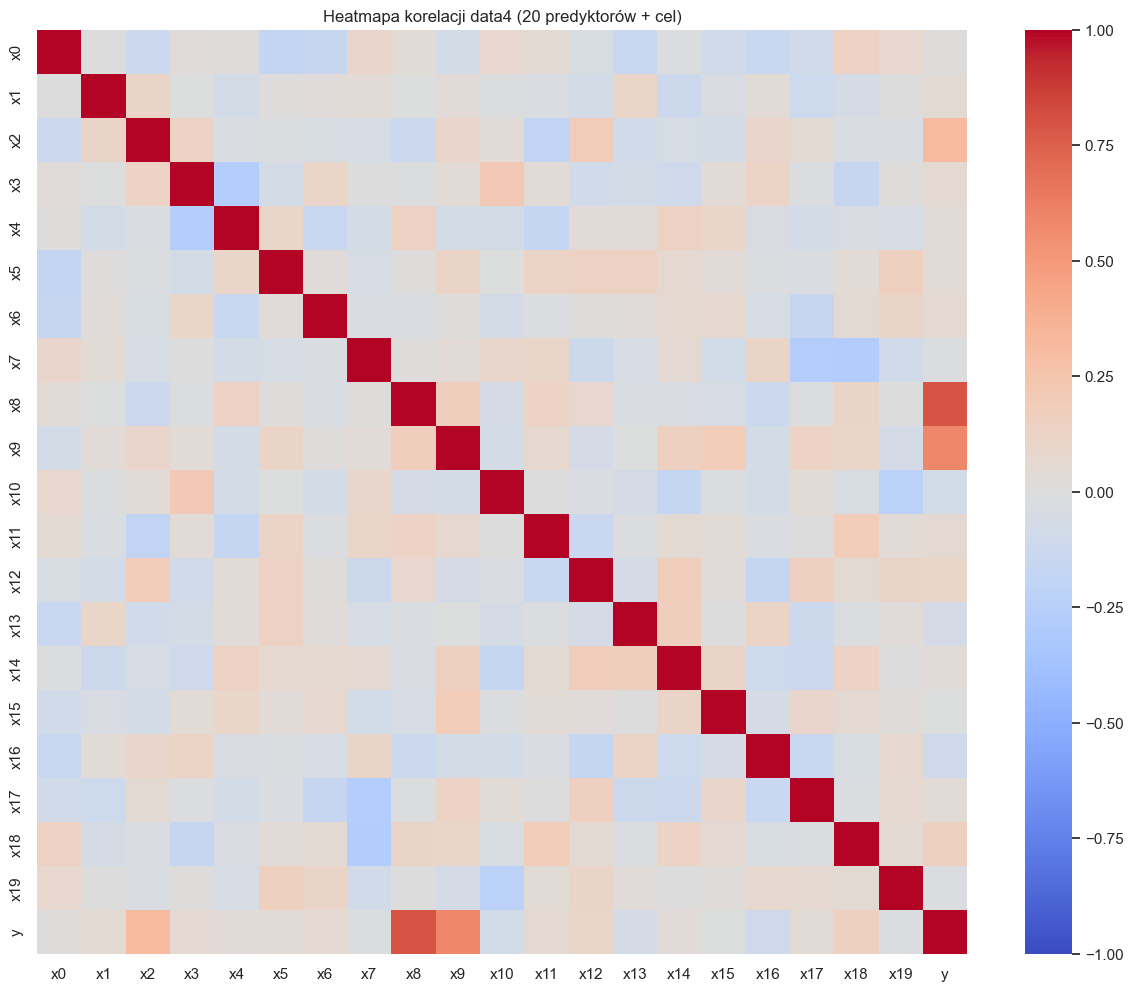

In [22]:
X_data4 = data4.drop('y', axis=1)
y_data4 = data4['y']

correlation_matrix_4 = data4.corr()


print("--- Korelacja predyktorów ze zmienną celu (y) ---")
print(correlation_matrix_4['y'].sort_values())

print("\n--- Heatmapa macierzy korelacji (szukamy współliniowości) ---")
plt.figure(figsize=(15, 12))
sns.heatmap(
    correlation_matrix_4,
    annot=False,
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title("Heatmapa korelacji data4 (20 predyktorów + cel)")
plt.show()

Widzimy, że x8 (i moze x9) jest najsilniejszym predyktorem.
Nie ma zadnej wspolliniowosci.

In [23]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X_data4, y_data4, test_size=0.2, random_state=42
)

In [24]:
from sklearn.linear_model import LinearRegression, RidgeCV

In [25]:
model_4_raw = LinearRegression()
model_4_raw.fit(X_train_4, y_train_4)
coef_df_4_raw = pd.DataFrame(
    model_4_raw.coef_,
    index=X_data4.columns,
    columns=['Wspolczynnik']
)

display(coef_df_4_raw.head())

,Wspolczynnik
x0,8.896
x1,-0.692
x2,39.193
x3,0.494
x4,-1.763


In [26]:
alphas_to_test = np.logspace(-1, 3, 20) # kandydaci na hiperparametr. wystrzelone dane
model_4_ridge = RidgeCV(alphas=alphas_to_test, cv=5)

model_4_ridge.fit(X_train_4, y_train_4)

print(f"\nWybrany hiperparametr alpha przez Model 'RidgeCV' : {model_4_ridge.alpha_:.4f}")

coef_df_4_ridge = pd.DataFrame(
    model_4_ridge.coef_,
    index=X_data4.columns,
    columns=['Wspolczynnik w Ridge L2']
)

display(coef_df_4_ridge.head())


Wybrany hiperparametr alpha przez Model 'RidgeCV' : 0.2637


,Wspolczynnik w Ridge L2
x0,8.798
x1,-0.665
x2,38.953
x3,0.551
x4,-1.705


In [27]:
coef_df_4_raw = pd.DataFrame(
    model_4_raw.coef_,
    index=X_data4.columns,
    columns=['Waga (Zwykła)']
)

coef_df_4_ridge = pd.DataFrame(
    model_4_ridge.coef_,
    index=X_data4.columns,
    columns=['Waga (Ridge L2)']
)

coef_comparison_df = pd.concat([coef_df_4_raw, coef_df_4_ridge], axis=1)


coef_comparison_df['Różnica_Abs'] = (coef_comparison_df['Waga (Zwykła)'] - coef_comparison_df['Waga (Ridge L2)']).abs()

coef_comparison_df = coef_comparison_df.sort_values(by='Różnica_Abs', ascending=False)

print("Porównanie współczynników (10 najbardziej zmienionych):")
display(coef_comparison_df.head(10))
print("...")

Porównanie współczynników (10 najbardziej zmienionych):


,Waga (Zwykła),Waga (Ridge L2),Różnica_Abs
x8,79.140,78.779,0.361
x2,39.193,38.953,0.240
x6,10.385,10.286,0.100
x0,8.896,8.798,0.099
x5,0.491,0.431,0.059
x4,-1.763,-1.705,0.057
x3,0.494,0.551,0.057
x12,-2.389,-2.332,0.057
x15,-2.207,-2.263,0.056
x11,-1.729,-1.684,0.046


...


In [28]:
y_pred_4_raw = model_4_raw.predict(X_test_4)
y_pred_4_ridge = model_4_ridge.predict(X_test_4)

mse_raw_4 = mean_squared_error(y_test_4, y_pred_4_raw)
r2_raw_4 = r2_score(y_test_4, y_pred_4_raw)

mse_ridge_4 = mean_squared_error(y_test_4, y_pred_4_ridge)
r2_ridge_4 = r2_score(y_test_4, y_pred_4_ridge)

evaluation_results_4 = {
    'Model': ['Standardowa Regresja', 'Regresja L2 (Ridge)'],
    'MSE (Błąd Średniokwadratowy)': [mse_raw_4, mse_ridge_4],
    'R² (Współczynnik determinacji)': [r2_raw_4, r2_ridge_4]
}
evaluation_df_4 = pd.DataFrame(evaluation_results_4)

print("Tabela ewaluacji skuteczności:")
display(evaluation_df_4)

Tabela ewaluacji skuteczności:


,Model,MSE (Błąd Średniokwadratowy),R² (Współczynnik determinacji)
0,Standardowa Regresja,232.827,0.969
1,Regresja L2 (Ridge),233.503,0.969


Modele zadzialaly podobnie. Gdyby dane byly wspolliniowe to lepiej by zadzialal L2.